## Ajuste de los parámetros del modelo a datos reales de defunciones

In [1]:
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import datosporregion as dpr
from model import SEIRDmodel

Cargamos los datos que queremos usar (totales, por entidad, cdmx):

In [3]:
viajes = dpr.viajes_regiones()
casos = dpr.casos_regiones()

In [4]:
modelo = SEIRDmodel(viajes, casos)

In [8]:
# ajuste = modelo.ajustar()

In [15]:
ynor = modelo.simular()
yred1 = modelo.simular(reduccionTrafico = 0.1)
yred2 = modelo.simular(reduccionTrafico = 0.5)

In [16]:
inf1 = ynor[[5*i + 2 for i in range(8)]]
inf2 = yred1[[5*i + 2 for i in range(8)]]
inf3 = yred2[[5*i + 2 for i in range(8)]]

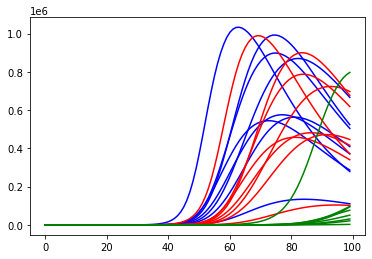

In [17]:
fig, ax = plt.subplots()

for _ in inf1:
    ax.plot(_, color = 'b')

for _ in inf2:
    ax.plot(_, color = 'red')
    
for _ in inf3:
    ax.plot(_, color = 'green')
    
plt.show()